In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/csv/processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


In [ ]:
data.HasDetections.value_counts()

0    99940
1    20012
Name: HasDetections, dtype: int64

Разделим выборку на тренировочную и тестовую

In [ ]:
y = data['HasDetections']
X = data.drop('HasDetections', axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.25, 
                                                     shuffle=True, 
                                                     random_state=1)

Обучите логистическую регрессию на тренировочной части наших данных, используя класс `LogisticRegression` из `sklearn.linear_model` с `l2` регуляризацией и коэффициентом регуляризации `C=0.01`. Ваш estimator должен нормировать данные по статистикам, рассчитывающимся на тренировочной выборке. Придется использовать конструкцию `Pipeline`. Положите все в переменную `pipe`.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

logis = LogisticRegression(penalty= "l2", C = 0.01)
pipe = Pipeline([("St",StandardScaler()),
                ("model",logis)])

In [ ]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('St', StandardScaler()),
                ('model', LogisticRegression(C=0.01))])

In [ ]:
pipe.score(X_test,y_test)

0.8421035080698946

Постройте ROC-кривую с помощью `RocCurveDisplay` и посчитайте `ROC-AUC` любым из показанных на практике способов. Один из вариантов - построить кривую с помощью `roc_curve` из `sklearn.metrics` и массивы пар `tpr-fpr` передать в `auc` из того же модуля `sklearn`. Проделайте эту операцию как для предсказаний на трейне, так и на тесте!

P.S. `roc_curve` необходимо скормить истинные метки классов (y_train/y_test), а также предсказанные вероятности (воспользуйтесь методом `predict_proba`)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import auc 

### На трейне
### Your code is here
fpr,tpr,tresh = roc_curve(y_test, pipe.predict_proba(X_test)[:,1])

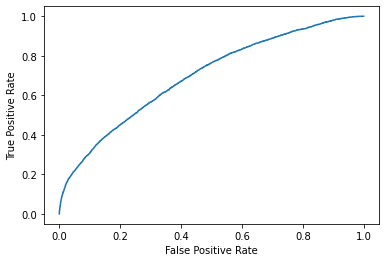

In [ ]:
RocCurveDisplay(fpr = fpr,tpr = tpr).plot()

In [ ]:
auc(fpr,tpr)

0.6968063498949493

In [ ]:
### На тесте
### Your code is here


Постройте PR-кривые на трейне и на тесте. Посчитайте PR-AUC

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay,precision_recall_curve

pr,rec,tresh = precision_recall_curve(y_test,pipe.predict_proba(X_test)[:,1])

### На трейне
### Your code is here

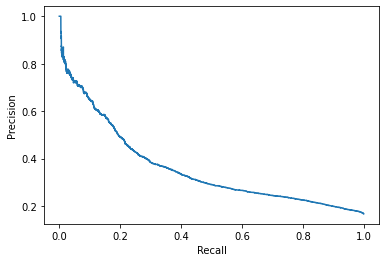

In [ ]:
PrecisionRecallDisplay(precision=pr,recall = rec).plot()

In [ ]:
### На тесте
### Your code is here

In [ ]:
auc(rec,pr)

0.35879592859023995

Построим калибровочную кривую. Хорошо ли откалиброван обученный классификатор? Сравним с калибровочной кривой для случайного классификатора!

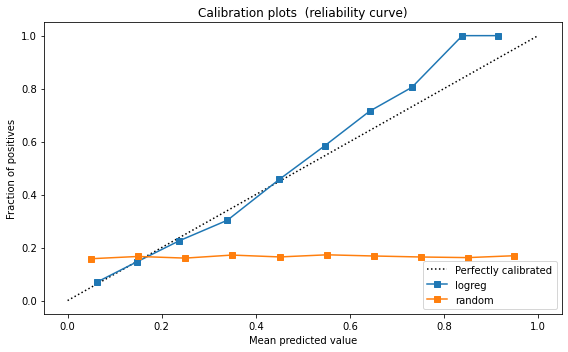

In [ ]:
from sklearn.calibration import calibration_curve
plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = pipe.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")

### Пусть наши предсказания - случайные, то есть для каждого объекта
### вероятность принадлежности + классу это просто случайное число [0; 1]
prob_pos = np.random.uniform(size=(X_test.shape[0],))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()